In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

In [2]:
from descwl_shear_sims.simple_sim import Sim

## Make A WL Deblend Sim

In [10]:
data = Sim(
    rng=100, 
    epochs_per_band=1,
    gal_type='wldeblend').gen_sim()
#     wcs_kws=dict(
#         position_angle_range=(0, 360),
#         scale_frac_std=0.1,
#         dither_range=(-0.5, 0.5),
#         shear_std=0.1)).gen_sim()

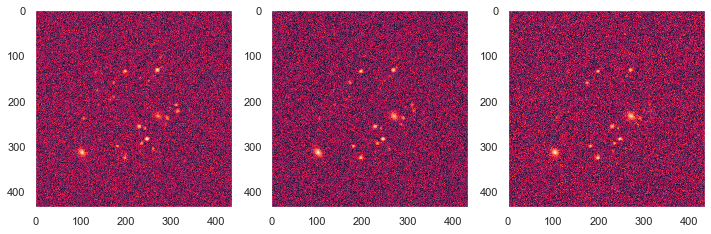

In [11]:
import numpy as np

fig, axs  = plt.subplots(ncols=3, figsize=(12, 4))

for band_ind, band in enumerate(data):
    for epoch_ind, obs in enumerate(data[band]):
        ax = axs[band_ind]
        ax.imshow(np.arcsinh(obs.image.array * np.sqrt(obs.weight.array[0, 0])))
        ax.grid(False)

## Build a Color Image

In [13]:
from numba import njit

@njit
def get_color_image(imr, img, imb, nonlinear, scales, colorim):
    """
    Create a color image.

    The idea here is that, after applying the asinh scaling, the color image
    should basically be between [0,1] for all filters.  Any place where a value
    is > 1 the intensity will be scaled back in all but the brightest filter
    but color preserved.

    In other words, you develaop a set of pre-scalings the images so that after
    multiplying by

        asinh(I/nonlinear)/(I/nonlinear)

    the numbers will be mostly between [0,1].  You can send scales using the
    scale= keyword

    It can actually be good to have some color saturation so don't be too
    agressive.  You'll have to play with the numbers for each image.

    Note also the image is clipped at zero.

    TODO:
        Implement a "saturation" level in the raw image values as in
        djs_rgb_make.  Even better, implement an outside function to do this.
    """

    nrows,ncols = imr.shape

    fac=1./nonlinear/3.

    for row in range(nrows):
        for col in range(ncols):
            rval = imr[row,col] * scales[0]
            gval = img[row,col] * scales[1]
            bval = imb[row,col] * scales[2]

            if rval < 0.0:
                rval=0.0
            if gval < 0.0:
                gval=0.0
            if bval < 0.0:
                bval=0.0

            # average images and divide by the nonlinear factor
            meanval = (rval + gval + bval)/3.0
            I = meanval/nonlinear

            if I <= 0.0:
                I = 1.0/3.0

            f = np.arcsinh(I)/I

            if (rval*f > 1) or (gval*f > 1) or (bval*f > 1):
                maxval = max(rval, gval, bval)
                if maxval > 0.0: 
                    f = 1.0/maxval

            colorim[row,col,0] = rval*f
            colorim[row,col,1] = gval*f
            colorim[row,col,2] = bval*f

In [29]:
data = Sim(
    rng=100, 
    epochs_per_band=1,
    bands=('g', 'r', 'i'),
    gal_type='wldeblend',
    gal_kws={'ngals_factor': 1}).gen_sim()


nonlin = 0.125
scales = np.array([0.8, 0.8, 1.5]) * 0.0004

r, c = data['r'][0].image.array.shape
colorim = np.zeros((r, c, 3))
get_color_image(
    data['i'][0].image.array,
    data['r'][0].image.array,
    data['g'][0].image.array,
    nonlin, 
    scales, 
    colorim)

final_img = (colorim * 255).astype('u1')

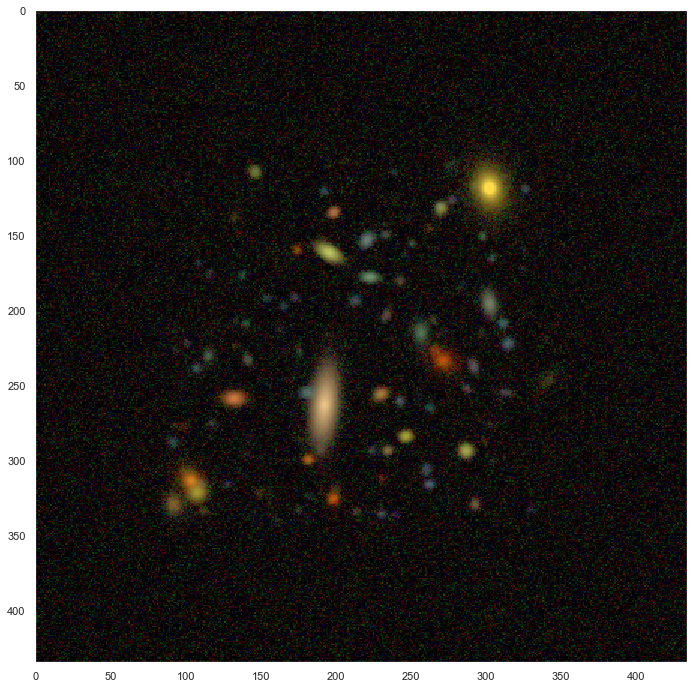

In [30]:
plt.figure(figsize=(12, 12))
plt.imshow(final_img)
plt.gca().grid(False)